<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/1615333-Найти-длину-факториала/Варианты-и-график.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Найти длину строки от Big факториала в питоне

К моему [ответу](https://ru.stackoverflow.com/a/1615337/430734) на
[вопрос на ruSO](https://ru.stackoverflow.com/q/1615333/430734).
В некоторых ячейках дублируются `import` что бы было проще проверять на [https://www.codewars.com/kata/59f34ec5a01431ab7600005a/train/python](
https://www.codewars.com/kata/59f34ec5a01431ab7600005a/train/python).

In [1]:
import math

def count(n):
    return 1 + int(math.lgamma(n + 1)*_count_log10_e)
    # return (1 + int(math.lgamma(n + 1)*_count_log10_e)
    #         + (n == 48_655_817)
    #         - (n in [46_464_264, 54_336_595, 54_528_830, 74_048_650]))

_count_log10_e = math.log10(math.e)
_count_ln_10 = math.log(10)
assert 1. == _count_log10_e*_count_ln_10

#----
for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5000000, 31323382), (50000000, 363233781)]:
    assert count(n) == f
for n in range(10):
    assert count(n) == len(str(math.factorial(n)))
print("Хорь")

Хорь


In [2]:
slow_tests = False

## Импорт

In [3]:
import ctypes
import decimal
import math
import os
import sys
import time
import urllib.request
import warnings

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import tqdm

try:
    import gmpy2
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython().config):
        %pip install -q -U gmpy2
    import gmpy2

if sys.platform.startswith('win'):
    libm = ctypes.cdll.msvcr120
elif sys.platform.startswith('darwin'):
    libm = ctypes.CDLL("libc.dylib")
elif sys.platform.startswith('freebsd'):
    libm = ctypes.CDLL("libm.so")
else:
    libm = ctypes.CDLL("libm.so.6")

try:
    %load_ext fortranmagic
except ModuleNotFoundError:
    # Example of install required packages for know enviroments
    if 'codespace' in str(get_ipython().config):
        !conda install -y -q -c conda-forge fortran-compiler
        %pip install -q -U fortran-magic 'setuptools>=76.1' meson \
                charset-normalizer ninja cmake pkgconfig
        print("WARNING: NEED RESTART")
        %load_ext fortranmagic
    elif 'google.colab' in str(get_ipython().config):
        %pip install -q -U fortran-magic meson \
                charset-normalizer ninja cmake pkgconfig
        %load_ext fortranmagic
        %fortran_config --backend meson -v
    else:
        assert False, """Can't load fortranmagic. For install:
                      pip install -U fortran-magic
                      or
                      conda install -c conda-forge fortran-magic
                      See: https://github.com/mgaitan/fortran_magic/blob/master/documentation.ipynb
                      """

## Ошибки точности

Внезапно, прям как зимний снегопад, оказалось, что для вычисления
длины факториала точности `float` бывает недостаточно. Причём, как
всегда, неожиданно рано. А в формуле длины факториала
$1 + \left\lfloor \log_{10} n! \right\rfloor$ предполагается,
что $\log_{10} n!$ не бывает целым, и точность промежуточных
вычислений должна позволять выяснить больше он ближайшего
целого или меньше.

1. Начиная с `n >= 28_563_732`, представление `float` (binary64
   по IEC 60559) значения  $\log_{10} \Gamma(n + 1)$ может
   оказываться целым (немного повезло, что первое округление в удачную
   сторону, поэтому собственно ошибки `count(n)` начинаются немного
   позднее, с `n >= 46_464_264`);
3. Так же, лично для меня, оказалась неожиданностью, что у `CPython`
   своя собственная реализация гамма-функции и она несколько хуже,
   чем стандартные BSD/macOS/Microsoft и даже `glibc` (мой
   поверхностный поиск не дал информации о точности реализации [math.lgamma](
   https://github.com/python/cpython/blob/main/Modules/mathmodule.c),
   но комментарии "it's probably not worth it", как бы, намекают).

Конечно, в условиях не сказано, какой должен быть диапазон, однако,
исходя из `test.assert_equals(count(50000000),363233781)` можно
использовать поправку
`+ (n == 48_655_817) - (n in [46_464_264, 54_336_595, 54_528_830, 74_048_650])`.
типа, с двойным запасом.

Впрочем, есть парочка, в некотором смысле, более честных, хотя и
заметно менее эффективных решений.

In [4]:
# `count()` иногда выдаёт неверную длину факториала
assert count(46_464_264) > 336067875
assert count(48_655_817) < 352892875
assert count(54_336_595) > 396700505
# Основная причина:
assert 336067875.0 == math.lgamma(46_464_264 + 1)*_count_log10_e
assert 396700505.0 == math.lgamma(54_336_595 + 1)*_count_log10_e
# Иногда к основной причине добавляется ошибка CPython
libm.lgamma.restype = ctypes.c_double
libm.lgamma.argtypes = (ctypes.c_double,)
assert 352892874.0 == libm.lgamma(48_655_817 + 1)*_count_log10_e
assert 352892874.0 != math.lgamma(48_655_817 + 1)*_count_log10_e
assert (float.fromhex('0x1.508b7c9ffffffp+28')
        == math.lgamma(48_655_817 + 1)*_count_log10_e)
print("Хорь")

Хорь


## `gmpy2.lgamma()`

Поскольку на [codewars.com](
https://www.codewars.com/kata/59f34ec5a01431ab7600005a/train/python)
есть `gmpy2` (жаль, что нет православного `mpmath`), то решение на нём
будет самым коротким среди тех, у которых диапазон много больше
`50_000_000` (точность по умолчанию 107-бит, имитирует точность
компенсационной арифметики, а ля double-double, алгоритмы Кэхана,
Неймура и т.п.).

In [5]:
import gmpy2

def gcount(n, precision=107, check=True, **kwargs):
    with gmpy2.context(precision=precision, **kwargs):
        log10_e = gmpy2.log10(gmpy2.exp(1))
        l10g = gmpy2.lgamma(n + 1)[0]*log10_e
        i, f = gmpy2.modf(l10g)
        if check and l10g:
            l10ge = gmpy2.next_above(l10g) - gmpy2.next_below(l10g)
            if f < l10ge or 1 - f < l10ge:
                # Как вариант, рекурсивный вызов с повышенной точностью
                raise ValueError(f"Не хватает точности {f, l10ge=}")
        return 1 + i

#----
for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5000000, 31323382), (50000000, 363233781)]:
    assert gcount(n) == f
for n in range(10):
    assert gcount(n) == len(str(math.factorial(n)))
assert gcount(46_464_264) == 336067875
try:
    gcount(46_464_264, precision=54)
    failValueError = True
except ValueError as e:
    failValueError = False
    print(e)
assert not failValueError
assert (gcount(46_464_264, precision=54, check=False)
        == gcount(46_464_264))
assert (gcount(46_464_264, precision=53, check=False)
        != gcount(46_464_264))
assert gcount(48_655_817) == 352892875
try:
    gcount(48_655_817, precision=54)
    failValueError = True
except ValueError as e:
    failValueError = False
    print(e)
assert not failValueError
assert (gcount(48_655_817, precision=54, check=False)
        == gcount(48_655_817))
assert (gcount(48_655_817, precision=53, check=False)
        == gcount(48_655_817))
assert (gcount(100**500, precision=10**4) ==
        gcount(100**500, precision=2*10**4))
print("Хорь")

Не хватает точности f, l10ge=(mpfr('0.999999970197677612',54), mpfr('5.9604644775390625e-08',54))
Не хватает точности f, l10ge=(mpfr('2.98023223876953125e-08',54), mpfr('5.9604644775390625e-08',54))
Хорь


## `decimal` и ряд Стирлинга

Решение на "чистом" Python, честно покрывающее диапазон до
`50_000_000` и далее, увы, немного длиннее предыдущего и
ещё немного медленнее (`math.lgamma()` ∼ 300 нс,
`gmpy2.lgamma()` ∼ 30 мкс, а используя `decimal` ∼ 200 мкс),
но, главное, оно тоже `O(1)`. Точность `decimal` по
умолчанию - 28 знаков (≥ 93 бита), её хватит на многие и
многие миллиарды. 😉

In [6]:
import decimal

def dcount(n, check=True, **kwargs):
    with decimal.localcontext(**kwargs):
        log10_e = decimal.Decimal(1).exp().log10()
        lg, lge = decimal_simple_lgamma(n + 1)
        l10g = lg*log10_e
        i = int(l10g)
        if check and l10g:
            l10ge = lge*log10_e
            f = l10g - i
            if f < l10ge or 1 - f < l10ge:
                # Как вариант, рекурсивный вызов с повышенной точностью
                raise ValueError(f"Не хватает точности {n, f, l10ge=}")
        return 1 + i

def decimal_simple_lgamma(x) -> tuple:
    """Простая реализация логарифма гамма-функции для оценки
       длины факториала. Использует только первый член ряда
       Стирлинга (A046968, A046969), он же является оценкой
       остаточного члена ряда сверху.
    """
    n = decimal.Decimal(x) - 1
    if 0 == n or 1 == n:
        return (decimal.Decimal(0), decimal.Decimal(0))
    pi = decimal.Decimal('3.14159265358979323846264338327950288419'
                         '7169399375105820974944592307816406286209')
    lg = n*n.ln() - n + (2*pi*n).ln()/2
    n12 = 12*n
    err = 1/n12 - 1/(n12 + 1)
    return (lg + err, abs(err) + 2*(lg.next_plus() - lg.next_minus()))

#----
for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5000000, 31323382), (50000000, 363233781)]:
    assert dcount(n) == f
for n in range(1000):
    assert dcount(n) == len(str(math.factorial(n)))
assert dcount(46_464_264) == 336067875
try:
    dcount(46_464_264, prec=16)
    failValueError = True
except ValueError as e:
    failValueError = False
    print(e)
assert not failValueError
assert (dcount(46_464_264, prec=17, check=False)
        == dcount(46_464_264))
assert (dcount(46_464_264, prec=16, check=False)
        != dcount(46_464_264))
assert dcount(54_336_595) == 396700505
try:
    dcount(54_336_595, prec=16)
    failValueError = True
except ValueError as e:
    failValueError = False
    print(e)
assert not failValueError
assert (dcount(54_336_595, prec=17, check=False)
        == dcount(54_336_595))
assert (dcount(54_336_595, prec=16, check=False)
        == dcount(54_336_595))
assert (dcount(100**500, prec=2*10**3) ==
        gcount(100**500, precision=2*10**4))
print("Хорь")

Не хватает точности n, f, l10ge=(46464264, Decimal('1E-7'), Decimal('1.737177927626977E-7'))
Не хватает точности n, f, l10ge=(54336595, Decimal('0.9999999'), Decimal('1.737177927623222E-7'))
Хорь


## Double-double `math.fsum()` логарифмов

Получаем компенсационную сумму путём двойного суммирования
`math.fsum()` (или `sum()` для >=3.12).

Выбор основания логарифма 10, конечно, удобен и позволяет
сократить одну константу, но с точки зрения точности и
производительности, всё-таки стоит брать: `2` или `e`.
Наверное удобнее `e`, и формулы компактнее (я с оценкой
ошибки для основания 10 запутался, а может там у библиотек
свои особенности), да и сравнивать с гамма-функцией
немного проще.

Точность неплохая, вроде бы реальные ошибки начинаются с
`n >= 40_752_166_709` (зависит от основания и реализации,
для 10 существенно раньше, для 2 немного позже). Пока
неясно, как дойти до этого числа на Python, лично я
использовал NumPy модуль на Фортране для компенсационного
суммирования.

Способ оценки ошибки для этого алгоритма неясен. Можно
прикинуть примерно так: пусть у нас $\ln x$ рассчитывается
с точностью $\pm 0.5 \varepsilon$, типа, дисперсия
$\sigma^2 \approx \frac{\varepsilon^2}{12}$:

$$ СКО{\left(\sum_{i=1}^{n} N_{i}(0, \sigma) \ln{i} \right)} \approx
   \sigma \sqrt{\int_{1}^{n} \ln^{2}{x} \ dx} =
   \sigma \sqrt{n \left( \ln^{2}{n} - 2 \ln{n} + 2 \right) - 2}$$

Эта оценка, предположительно, даёт ложноотрицательные ошибки,
примерно 2..3 штуки на 10<sup>9</sup>. Однако, ввиду низкой
скорости этого способа ∼ `O(n)`, нет
особой необходимости в её точности, т.к. большие значения
`n` трудно доступны (трудно вычислимы). Тем не менее,
контроль времени на codewars, с трудом, но проходит.

In [7]:
def sum_ln_err(n):
    return (math.ulp(1)/math.sqrt(12))*math.sqrt(
                n*(math.log(n)**2 - 2*math.log(n) + 2) - 2)

class two_factorial_length_np:
    _chunk_size = 20_000
    _sum_not_double_double = (1e-37 != sum([1., 1e-37, -1.]))
    def __init__(self, fsum=_sum_not_double_double):
        self.fsum = fsum
        self.n = 1
        self.sum = np.zeros(2)
        self.res = 1
    def __call__(self, n, check=True):
        if n <= 1:
            return 1
        if self.n == n:  # TODO: check при повторном вызове игнорируется?
            return self.res
        assert self.n < n
        while self.n < n:
            c = min(n, self.n + self._chunk_size)
            a = np.arange(self.n + 1, c + 1 + 3, dtype=float)
            a[:-3] = np.log(a[:-3])
            a[-3:-1] = self.sum
            if self.fsum:
                self.sum[0] = math.fsum(a[:-1])
                a[-1] = -self.sum[0]
                self.sum[1] = math.fsum(a)
            else:
                self.sum[0] = sum(a[:-1].tolist())
                a[-1] = -self.sum[0]
                self.sum[1] = sum(a.tolist())
            assert self.sum[0] == self.sum[0] + self.sum[1]
            self.n = c
        l10g = two_mul(self.sum, _two_log10_e)
        i = two_floor(l10g)
        self.res = 1 + i
        if check and l10g[0]:
            f = two_add(l10g, -i)  # TODO: случай i >= 2**53
            err = sum_ln_err(self.n)*_two_log10_e[0]
            if f[0] <= err or (1 - f[0]) <= err:
                raise ValueError(f"Не хватает точности {f, err=}")
        return self.res

_codewars_state = two_factorial_length_np()
def _codewars_count(n):
    global _codewars_state
    if n <= 1:
        return 1
    if n < _codewars_state.n:
        _codewars_state = two_factorial_length_np()
    return _codewars_state(n)

#----
# Функции double-double

# Половина нужна для умножения на константу, однако, другая
# половина требуется для контроля точности (вычитания) и
# небольшая функция two_floor()

def quick_two_sum(a, b) -> tuple:
    assert abs(a) >= abs(b)
    hi = a + b
    lo = b - (hi - a)
    assert hi == hi + lo
    return hi, lo

def two_sum(a, b) -> tuple:
    if abs(a) >= abs(b):
        return quick_two_sum(a, b)
    return quick_two_sum(b, a)

def two_add(a: tuple, b) -> tuple:
    if isinstance(b, tuple):
        hi, lo = two_sum(a[0], b[0])
        lh, ll = two_sum(a[1], b[1])
        lo += lh
        hi, lo = two_sum(hi, lo)  # TODO:??? quick_two_sum(hi, lo)
        lo += ll
    else:
        hi, lo = two_sum(a[0], b)
        lo += a[1]
    return two_sum(hi, lo)  # TODO:??? quick_two_sum(hi, lo)

if 'fma' in math.__dict__:
    two_fma = math.fma
else:
    # Для <3.13 есть pyfma, libc (ctypes) или известный сплит-алгоритм
    libm.fma.restype = ctypes.c_double
    libm.fma.argtypes = (ctypes.c_double, ctypes.c_double, ctypes.c_double)
    two_fma = libm.fma

def two_prod(a, b) -> tuple:
    hi = a * b
    lo = two_fma(a, b, -hi)
    assert hi == hi + lo
    return hi, lo

def two_mul(a: tuple, b: tuple) -> tuple:
    assert a[0] == a[0] + a[1]
    assert b[0] == b[0] + b[1]
    hi, lo = two_prod(a[0], b[0])
    lo += a[0] * b[1]
    lo += a[1] * b[0]
    return quick_two_sum(hi, lo)

def two_floor(a: tuple) -> int:
    assert a[0] == a[0] + a[1]
    i = math.floor(a[0])
    if i == a[0]:
        return i + math.floor(a[1])
    return i

assert (two_prod(float.fromhex('0x1.0000000000001p+0'),
                 float.fromhex('0x1.0000000000001p+0'))
        == (float.fromhex('0x1.0000000000002p+0'),
            float.fromhex('0x1.0000000000000p-104')))
assert (two_mul(two_prod(float.fromhex('0x1.0000000000001p+0'),
                         float.fromhex('0x1.0000000000001p+0')),
                two_prod(float.fromhex('0x1.fffffffffffffp-1'),
                         float.fromhex('0x1.fffffffffffffp-1')))
        == (float.fromhex('0x1.0000000000001p+0'),
            float.fromhex('-0x1.8000000000002p-105')))
assert 1 == two_floor((float.fromhex('0x1.0000000000001p+0'),
                       float.fromhex('-0x1.8000000000002p-105')))
assert 0 == two_floor((float.fromhex('0x1.0000000000000p+0'),
                       float.fromhex('-0x1.8000000000002p-105')))

with decimal.localcontext(prec = sys.float_info.dig*3) as ctx:
    _two_log10_e = decimal.Decimal(1).exp().log10()
    _two_log10_e_hi = float(_two_log10_e)
    _two_log10_e_lo = float(_two_log10_e -
                            decimal.Decimal(_two_log10_e_hi))
    assert _two_log10_e_hi == _two_log10_e_hi + _two_log10_e_lo
    _two_log10_e = (_two_log10_e_hi, _two_log10_e_lo)
    _two_ln_10 = decimal.Decimal(10).ln()
    _two_ln_10_hi = float(_two_ln_10)
    _two_ln_10_lo = float(_two_ln_10 -
                          decimal.Decimal(_two_ln_10_hi))
    assert _two_ln_10_hi == _two_ln_10_hi + _two_ln_10_lo
    _two_ln_10 = (_two_ln_10_hi, _two_ln_10_lo)
_test_one = two_mul(_two_log10_e, _two_ln_10)
assert 1 == _test_one[0]
assert 1 >= _test_one[1]/math.ulp(0.5)**2

#----
for fsum_want in range(two_factorial_length_np()._sum_not_double_double, 2):
    print(f"fsum={fsum_want}: ", end="")
    dt = -time.time()
    tfl = two_factorial_length_np(fsum=fsum_want)
    assert 7 == tfl(10)
    assert 19 == tfl(20)
    assert 7 == two_factorial_length_np(fsum=fsum_want)(10)
    assert 19 == two_factorial_length_np(fsum=fsum_want)(20)
    tfl = two_factorial_length_np(fsum=fsum_want)
    for n, f in ([(5, 3), (50, 65), (500, 1135), (5000, 16326),
                  (50000, 213237), (500000, 2632342),
                  (5_000_000, 31323382),] +
                 ([(28_563_732, gcount(28_563_732)),
                   (44_315_509, gcount(44_315_509)),
                   (46_464_264, gcount(46_464_264)),
                   (48_655_817, gcount(48_655_817)),
                   (50_000_000, 363233781),
                   (50_000_000, 363233781),
                   (71_764_514, gcount(71_764_514)),
                   (74_048_650, gcount(74_048_650)),
                   (114_636_184, gcount(114_636_184))]
                  if globals().get('slow_tests') else [])):
        assert tfl(n) == f
    for n in range(10):
        assert (two_factorial_length_np(fsum=fsum_want)(n) ==
                len(str(math.factorial(n))))
    dt += time.time()
    print(f"{dt:.3f}")
print("Хорь")
# Хорь 10.9/18.7

fsum=0: 0.425
fsum=1: 0.747
Хорь


In [8]:
class two_factorial_length:
    _chunk_size = 20_000
    _sum_not_double_double = (1e-37 != sum([1., 1e-37, -1.]))
    def __init__(self, fsum=_sum_not_double_double):
        self.fsum = fsum
        self.n = 1
        self.sum = [0., 0.]
        self.res = 1
    def __call__(self, n, check=True):
        if n <= 1:
            return 1
        if self.n == n:  # TODO: check при повторном вызове игнорируется?
            return self.res
        assert self.n < n
        while self.n < n:
            c = min(n, self.n + self._chunk_size)
            a = self.sum + [math.log(i) for i in range(self.n + 1, c + 1)]
            if self.fsum:
                self.sum[0] = math.fsum(a)
                a.append(-self.sum[0])
                self.sum[1] = math.fsum(a)
            else:
                self.sum[0] = sum(a)
                a.append(-self.sum[0])
                self.sum[1] = sum(a)
            assert self.sum[0] == self.sum[0] + self.sum[1]
            self.n = c
        l10g = two_mul(self.sum, _two_log10_e)
        i = two_floor(l10g)
        self.res = 1 + i
        if check and l10g[0]:
            f = two_add(l10g, -i)  # TODO: случай i >= 2**53
            err = sum_ln_err(self.n)*_two_log10_e[0]
            if f[0] <= err or (1 - f[0]) <= err:
                raise ValueError(f"Не хватает точности {f, err=}")
        return self.res

_codewars_state = two_factorial_length()
def _codewars_count(n):
    global _codewars_state
    if n <= 1:
        return 1
    if n < _codewars_state.n:
        _codewars_state = two_factorial_length()
    return _codewars_state(n)


#----
for fsum_want in range(two_factorial_length()._sum_not_double_double, 2):
    print(f"fsum={fsum_want}: ", end="")
    dt = -time.time()
    tfl = two_factorial_length(fsum=fsum_want)
    assert 7 == tfl(10)
    assert 19 == tfl(20)
    assert 7 == two_factorial_length(fsum=fsum_want)(10)
    assert 19 == two_factorial_length(fsum=fsum_want)(20)
    tfl = two_factorial_length(fsum=fsum_want)
    for n, f in ([(5, 3), (50, 65), (500, 1135), (5000, 16326),
                  (50000, 213237), (500000, 2632342),
                  (5_000_000, 31323382),] +
                 ([(28_563_732, gcount(28_563_732)),
                   (44_315_509, gcount(44_315_509)),
                   (46_464_264, gcount(46_464_264)),
                   (48_655_817, gcount(48_655_817)),
                   (50_000_000, 363233781),
                   (50_000_000, 363233781),
                   (71_764_514, gcount(71_764_514)),
                   (74_048_650, gcount(74_048_650)),
                   (114_636_184, gcount(114_636_184))]
                  if globals().get('slow_tests') else [])):
        assert tfl(n) == f
    for n in range(10):
        assert (two_factorial_length(fsum=fsum_want)(n) ==
                len(str(math.factorial(n))))
    dt += time.time()
    print(f"{dt:.3f}")
print("Хорь")
# Хорь 14.9/17.4 (без assert ??.?/17.7)

fsum=0: 0.615
fsum=1: 0.727
Хорь


## Double-double и `math.lgamma()`

До формальных `50_000_000` точности не хватает немного, так что
можно просто улучшить точность результата путём "усреднения"
нескольких результатов для близких аргументов.

Пока так себе способ, тормозная и очень сырая идея. Пока зависит
от библиотеки, собственно на `math.lgamma()` хоть как-то устойчиво
работать заставить не удалось. Но со стандартными `libm.lgamma()`
дышит более менее устойчиво.

С оценкой ошибки тоже пока проблема. Типа, сначала срабатывает,
но потом перестаёт...

In [9]:
import decimal

def two_count(n, avg=6, check=True):
    l10g = two_mul(two_lgamma(n + 1, avg=avg), _two_log10_e)
    i = two_floor(l10g)
    if check and l10g[0]:
        f = two_add(l10g, -i)  # TODO: случай i >= 2**53
        # TODO: Вариант оценки ошибки как avg=(avg - 1) ни хрена не обоснован
        l10ge = two_add(two_mul(two_lgamma(n + 1, avg=(avg - 1)), _two_log10_e),
                        (-l10g[0], -l10g[1]))
        if f[0] <= abs(l10ge[0]) or (1 - f[0]) <= abs(l10ge[0]):
            raise ValueError(f"Не хватает точности {f, l10ge=}")
    return 1 + i

def two_lgamma(x, avg):
    """Для получения большой точности, необходимой при оценке
       длины факториала, усредняем значение `libm.lgamma()` в
       двух `float` (double-doble) исходя из Γ(x + 1) = x*Γ(x).

       ln(Γ(x)) = ln(Γ(x + 1)) - ln(x)
       ln(Γ(x)) = ln(Γ(x + 2)) - ln(x) - ln(x + 1)
       ...
       ln(Γ(x)) = ln(Γ(x - 1)) + ln(x - 1)
       ln(Γ(x)) = ln(Γ(x - 2)) + ln(x - 1) + ln(x - 2)
       ...
    """
    n = 2**avg
    if x <= n and x == int(x):  # TODO нет тестов для нецелых x
        return math.lgamma(x), 0.
    ll = ([libm.lgamma(x + i)  for i in range(n)] +
          [-math.log(x + j)    for i in range(n) for j in range(i)] +
          [libm.lgamma(x - i)  for i in range(n)] +
          [math.log(x - 1 - j) for i in range(n) for j in range(i)])
    hi = math.fsum(ll)
    lo = math.fsum((*ll, -hi))
    n *= 2
    hi, lo = hi/n, lo/n  # На степень 2 - точное деление
    assert hi == hi + lo
    return hi, lo

#----
for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5_000_000, 31323382),
             (28_563_732, gcount(28_563_732)),
             (44_315_509, gcount(44_315_509)),
             (46_464_264, gcount(46_464_264)),
             (48_655_817, gcount(48_655_817)),
             (50_000_000, 363233781),
             (50_000_000, 363233781),
             (71_764_514, gcount(71_764_514)),
             (74_048_650, gcount(74_048_650)),
             (114_636_184, gcount(114_636_184))]:
    assert two_count(n) == f
for n in range(10):
    assert two_count(n) == len(str(math.factorial(n)))
print('Хорь')

Хорь


## Double-double поэлементная сумма логарифмов

На Python пока не получается выразить эффективный однопроходный
алгоритм суммирования. Однака, наверное, потенциально, для
`np.array` можно сделать `two_sum()` и суммировать подмассивы
по степеням двойки, что также должно дать ускорение в несколько
раз. Но всё равно, сложность `O(n)`.

В отличие от предыдущих вариантов, с Фортран на `codewars` не
сунешься.

In [10]:
%%fortran -v
subroutine two_array_sum(a, n, start, res)
    implicit none
    integer n
    real*8, intent(in) :: a(n), start(2)
    real*8, intent(out) :: res(2)
    real*8 hi, lo
    real*8 t, u
    integer i
    hi = start(1)
    lo = start(2)
    do i = 1, n
        t = hi + a(i)
        if (abs(hi) >= abs(a(i))) then
            u = (hi - t) + a(i)
        else
            u = (a(i) - t) + hi
        endif
        hi = t
        lo = lo + u
    end do
    res(1) = hi + lo
    if (abs(hi) >= abs(lo)) then
        res(2) = lo - (res(1) - hi)
    else
        res(2) = hi - (res(1) - lo)
    endif
end subroutine two_array_sum

subroutine two_array_sum3(a, n, start, res)
    implicit none
    integer n
    real*8, intent(in) :: a(n), start(3)
    real*8, intent(out) :: res(3)
    real*8 hi, me, lo
    real*8 t, u, v
    integer i
    hi = start(1)
    me = start(2)
    lo = start(3)
    do i = 1, n
        t = hi + a(i)
        if (abs(hi) >= abs(a(i))) then
            u = (hi - t) + a(i)
        else
            u = (a(i) - t) + hi
        endif
        hi = t
        t = me + u
        if (abs(me) >= abs(u)) then
            v = (me - t) + u
        else
            v = (u - t) + me
        endif
        me = t
        lo = lo + v
    end do
    ! TODO: проверить renorm
    t = hi + me
    if (abs(hi) >= abs(me)) then
        u = me - (t - hi)
    else
        u = hi - (t - me)
    endif
    hi = t
    me = u

    t = me + lo
    if (abs(me) >= abs(lo)) then
        v = lo - (t - me)
    else
        v = me - (t - lo)
    endif
    me = t
    lo = v

    t = hi + me
    if (abs(hi) >= abs(me)) then
        u = me - (t - hi)
    else
        u = hi - (t - me)
    endif
    hi = t
    me = u

    res(1) = hi
    res(2) = me
    res(3) = lo
end subroutine two_array_sum3


Ok. The following fortran objects are ready to use: two_array_sum, two_array_sum3


In [11]:
class two_factorial_length_single_pass:
    _chunk_size = 20_000
    def __init__(self):
        self.n = 1
        self.sum = np.zeros(2, dtype=float)
        self.res = 1
    def __call__(self, n, check=True):
        if n <= 1:
            return 1
        if self.n == n:  # TODO: check при повторном вызове игнорируется?
            return self.res
        assert self.n < n
        while self.n < n:
            c = min(n, self.n + self._chunk_size)
            a = np.log(np.arange(self.n + 1, c + 1, dtype=float))
            self.sum = two_array_sum(a, self.sum)
            assert self.sum[0] == self.sum[0] + self.sum[1]
            self.n = c
        l10g = two_mul(self.sum, _two_log10_e)
        i = two_floor(l10g)
        self.res = 1 + i
        if check and l10g[0]:
            f = two_add(l10g, -i)  # TODO: случай i >= 2**53
            err = sum_ln_err(self.n)*_two_log10_e[0]
            if f[0] <= err or (1 - f[0]) <= err:
                raise ValueError(f"Не хватает точности {f, err=}")
        return self.res

#----
dt = -time.time()
tfl = two_factorial_length_single_pass()
assert 7 == tfl(10)
assert 19 == tfl(20)
assert 7 == two_factorial_length_single_pass()(10)
assert 19 == two_factorial_length_single_pass()(20)
tfl = two_factorial_length_single_pass()
for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5_000_000, 31323382),
             (28_563_732, gcount(28_563_732)),
             (44_315_509, gcount(44_315_509)),
             (46_464_264, gcount(46_464_264)),
             (48_655_817, gcount(48_655_817)),
             (50_000_000, 363233781),
             (50_000_000, 363233781),
             (71_764_514, gcount(71_764_514)),
             (74_048_650, gcount(74_048_650)),
             (114_636_184, gcount(114_636_184))]:
    assert tfl(n) == f
for n in range(10):
    assert two_factorial_length_single_pass()(n) == len(str(math.factorial(n)))
dt += time.time()
print("Хорь", dt)
# log2 1.06 .. 1.15
# log1p 1.51 .. 1.57
# log 1.11 .. 1.17

Хорь 1.1029019355773926


## Сравнения

In [12]:
def lcount(n):
    return 1 + int(libm.lgamma(n + 1)*_count_log10_e)

for n, f in [(5, 3), (50, 65), (500, 1135), (5000, 16326), (50000, 213237),
             (500000, 2632342), (5000000, 31323382), (50000000, 363233781)]:
    assert lcount(n) == f
for n in range(10):
    assert lcount(n) == len(str(math.factorial(n)))
print("Хорь")

Хорь


In [13]:
if False and globals().get('slow_tests'):
    %timeit count(54_336_595)
    %timeit lcount(54_336_595)
    %timeit gcount(54_336_595)
    %timeit dcount(54_336_595)
    %timeit two_count(54_336_595)
    %timeit two_factorial_length_single_pass()(54_336_595)
    #%timeit two_factorial_length_np()(54_336_595)
    #%timeit two_factorial_length()(54_336_595)
# 333 ns ± 3.89 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
# 892 ns ± 9.17 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
# 25.8 μs ± 105 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 204 μs ± 1.69 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 1.09 ms ± 1.49 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
# 513 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 4.77 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 6.8 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

## Оценки точности

In [14]:
f_cond_prec = "15_17"
f_decimal = 19
f_fname = f"i64-{f_cond_prec}-{f_decimal}.txt.bz2"
f_dname = "out_i64"
f_fpath = f"{f_dname}/{f_fname}"
f_urlbase = "https://github.com/Serge3leo/temp-cola/releases/download"
f_rel = "testrel-0.0"
f_url = f"{f_urlbase}/{f_rel}/{f_fname}"
if not ("f_load_facint" in globals() and "facint" in globals() and
        f_load_facint == (facint.shape, f_number[0], f_number[-1]) and
        globals().get('f_save_slow_test') == globals().get('slow_tests')):
    f_save_slow_test = globals().get('slow_tests')
    retry = 0
    while True:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore',
                                    r'Input line 1 contained no data.*max_rows=')
            try:
                facint = np.loadtxt(f_fpath,
                                    dtype=np.uint64, encoding='utf-8',
                                    **({} if globals().get('slow_tests')
                                       else dict(max_rows=3000)))
                break
            except (OSError, EOFError):  # TODO при ошибках - нестабильно
                assert 3 > retry, f"np.loadtxt() (загрузка) неуспех {retry=}"
                retry += 1
                print(f"Загрузка: {f_url, f_fname=}")
                os.makedirs(f_dname, exist_ok=True)
                urllib.request.urlretrieve(f_url, f_fpath)
    f_number = facint[:,0]
    f_low    = facint[:,1]
    f_high   = facint[:,2]
    f_exp    = facint[:,3]
    f_load_facint = (facint.shape, f_number[0], f_number[-1])
print(f"Хорь {f_number.shape[0]:_d} чисел до {f_number[-1]:_d}")

Хорь 3_000 чисел до 803_032_398


К сожалению, "i64-15_17-19.txt" был рассчитан наивным
последовательным умножением, поэтому для некоторой части
чисел остаётся неопределённость. По-хорошему, стоит
рассчитать для этих чисел интервалы, не последовательным
умножением, а по дереву (разложить на множители или ещё как).

Пока же проверяем совпадение с расчётом на иной точности, более
высокой.

In [15]:
f_mod = 10**f_decimal
f_lf = f_decimal + np.int64(f_exp)
df = np.where(f_high >= f_mod)[0]
print(f"{df.shape}")
cnt = np.zeros(3, dtype=int)
for i in df: # tqdm.tqdm(df):
    n = int(f_number[i])
    clf = (gcount(n), dcount(n), gcount(n, precision=256), dcount(n, prec=80))
    for j in range(1, 4):
        cnt[j - 1] += clf[0] != clf[j]
    f_lf[i] = int(clf[3])
assert not np.any(cnt)
print("Хорь")

(0,)
Хорь


In [16]:
for f, imax in [(count, 314),
                (gcount, 1_000_000),
                (dcount, 100_000),
                (two_count, 10_000),
                (two_factorial_length_single_pass(), 50_000),
                #(two_factorial_length_single_pass(), len(f_number)),
                (two_factorial_length_np(), 314),
                (two_factorial_length(), 123),]:
    print(f"{f}:")
    e0cnt = 0
    e1cnt = 0
    eok = 0
    for i in tqdm.trange(min(imax + 1, len(f_number))):
        n = int(f_number[i])
        clf = int(f_lf[i])
        try:
            lf = int(f(n))
            if clf == lf:
                continue
            e0cnt += 1
            print(f"{e0cnt:2} {e1cnt:7_d} {eok:7_d} "
                  f"{i:9_d} {n:15_d} {lf - clf}")
            if e0cnt > 7:
                break
        except ValueError as ex:
            lf = int(f(n, check=False))
            if clf == lf:
                e1cnt += 1
                if e1cnt <= 7:
                    print(f"{e0cnt:2} {e1cnt:7_d} {eok:7_d} "
                          f"{i:9_d} {n:15_d} False ValueError")
            else:
                eok += 1
                if eok <= 7:
                    print(f"{e0cnt:2} {e1cnt:7_d} {eok:7_d} "
                          f"{i:9_d} {n:15_d} {lf - clf} True ValueError")
    print(f"{e0cnt:2} {e1cnt:7_d} {eok:7_d} "
          f"{i:9_d} {n:15_d} Итог по {f}")
print("Хорь")

<function count at 0x112e219e0>:


100%|████████████████████████████████████▉| 314/315 [00:00<00:00, 392084.39it/s]


 1       0       0       105      46_464_264 1
 2       0       0       109      48_655_817 -1
 3       0       0       122      54_336_595 1
 4       0       0       123      54_528_830 1
 5       0       0       159      74_048_650 1
 6       0       0       255     114_636_184 1
 7       0       0       268     120_135_520 1
 8       0       0       314     136_071_211 -1
 8       0       0       314     136_071_211 Итог по <function count at 0x112e219e0>
<function gcount at 0x1161c93a0>:


100%|████████████████████████████████████| 3000/3000 [00:00<00:00, 31160.71it/s]


 0       0       0     2_999     803_032_398 Итог по <function gcount at 0x1161c93a0>
<function dcount at 0x1161c9760>:


100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 4654.69it/s]


 0       0       0     2_999     803_032_398 Итог по <function dcount at 0x1161c9760>
<function two_count at 0x1161caca0>:


 32%|████████████▌                          | 966/3000 [00:01<00:02, 877.72it/s]

 0       0       1       864     260_558_467 1 True ValueError
 0       1       1       967     292_497_248 False ValueError


 41%|███████████████▌                      | 1227/3000 [00:01<00:02, 853.03it/s]

 0       2       1     1_085     317_684_351 False ValueError
 0       2       2     1_094     319_466_107 -1 True ValueError
 0       2       3     1_251     364_469_152 1 True ValueError


 56%|█████████████████████                 | 1665/3000 [00:01<00:01, 864.29it/s]

 0       2       4     1_516     432_201_894 1 True ValueError
 0       3       4     1_557     443_954_754 False ValueError
 0       3       5     1_631     465_797_953 1 True ValueError


 61%|███████████████████████▎              | 1838/3000 [00:02<00:01, 844.90it/s]

 0       4       5     1_718     492_744_099 False ValueError
 1       4       5     1_736     496_585_177 -1
 1       5       5     1_778     506_667_368 False ValueError
 1       6       5     1_842     519_428_649 False ValueError
 1       7       5     1_886     530_140_562 False ValueError


 70%|██████████████████████████▌           | 2093/3000 [00:02<00:01, 835.10it/s]

 1       8       6     1_928     537_763_687 -1 True ValueError


 78%|█████████████████████████████▊        | 2349/3000 [00:02<00:00, 843.11it/s]

 2      12       6     2_255     623_188_578 1


 93%|███████████████████████████████████▏  | 2779/3000 [00:03<00:00, 850.90it/s]

 3      15       6     2_630     711_893_761 -1


100%|██████████████████████████████████████| 3000/3000 [00:03<00:00, 850.89it/s]


 3      19       7     2_873     773_258_046 1 True ValueError
 4      21       7     2_960     791_921_320 -1
 4      21       7     2_999     803_032_398 Итог по <function two_count at 0x1161caca0>
<__main__.two_factorial_length_single_pass object at 0x116253520>:


100%|██████████████████████████████████████| 3000/3000 [00:07<00:00, 378.38it/s]


 0       0       0     2_999     803_032_398 Итог по <__main__.two_factorial_length_single_pass object at 0x116253520>
<__main__.two_factorial_length_np object at 0x1161dea50>:


100%|█████████████████████████████████████████| 315/315 [00:11<00:00, 26.26it/s]


 0       0       0       314     136_071_211 Итог по <__main__.two_factorial_length_np object at 0x1161dea50>
<__main__.two_factorial_length object at 0x1161dd710>:


100%|█████████████████████████████████████████| 124/124 [00:06<00:00, 17.88it/s]

 0       0       0       123      54_528_830 Итог по <__main__.two_factorial_length object at 0x1161dd710>
Хорь


## График необходимой, для факториала, точности

Просто строим графики
$\frac{\left\{ \log_{10} n! \right\}}{\log_{10} n!}$ и
$\frac{1 - \left\{ \log_{10} n! \right\}}{\log_{10} n!}$, пытаемся
визуально понять зависимость.


In [17]:
if "g_f" not in globals() or "g_1f" not in globals():
    g_min = 25
    if 0:
        g_number = f_number[g_min:]
    else:
        g_number = f_number[g_min:500_000]
    g_f = np.empty_like(g_number, dtype=float)
    g_1f = np.empty_like(g_f)
    dt = -time.time()
    with gmpy2.context(precision=256):
        log10_e = gmpy2.log10(gmpy2.exp(1))
        for i in tqdm.trange(len(g_f)):
            l10g = gmpy2.lgamma(int(g_number[i] + 1))[0]*log10_e
            _, f = gmpy2.modf(l10g)
            if f <= 0.5:
                g_f[i] = f/l10g
                g_1f[i] = np.nan
            else:
                g_f[i] = np.nan
                g_1f[i] = (1 - f)/l10g
    dt += time.time()
    print(f"Хорь {dt:.2f}")

100%|████████████████████████████████████| 2975/2975 [00:00<00:00, 39039.55it/s]

Хорь 0.08


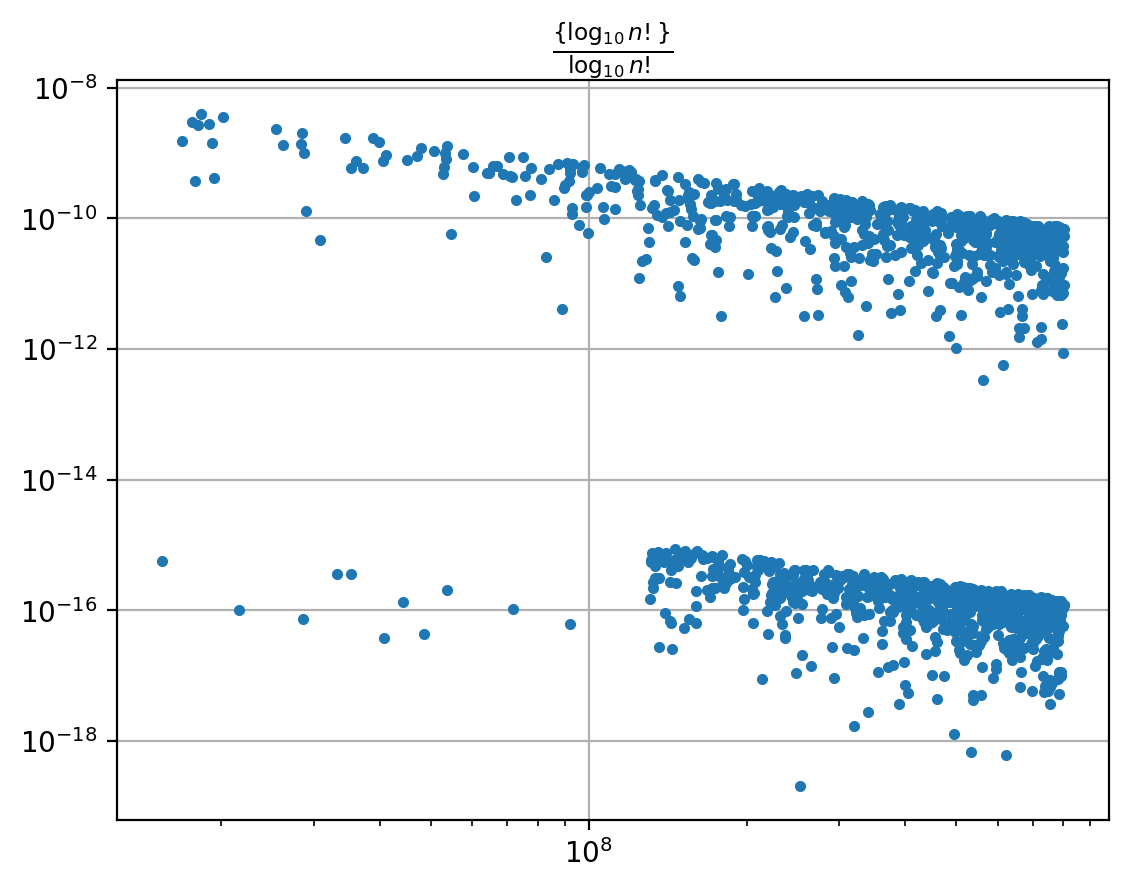

In [18]:
fig, ax = plt.subplots()
ax.set_title(r"$\frac{\left\{ \log_{10} n! \right\}}{\log_{10} n!}$")
ax.plot(g_number, g_f, ".")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.show()

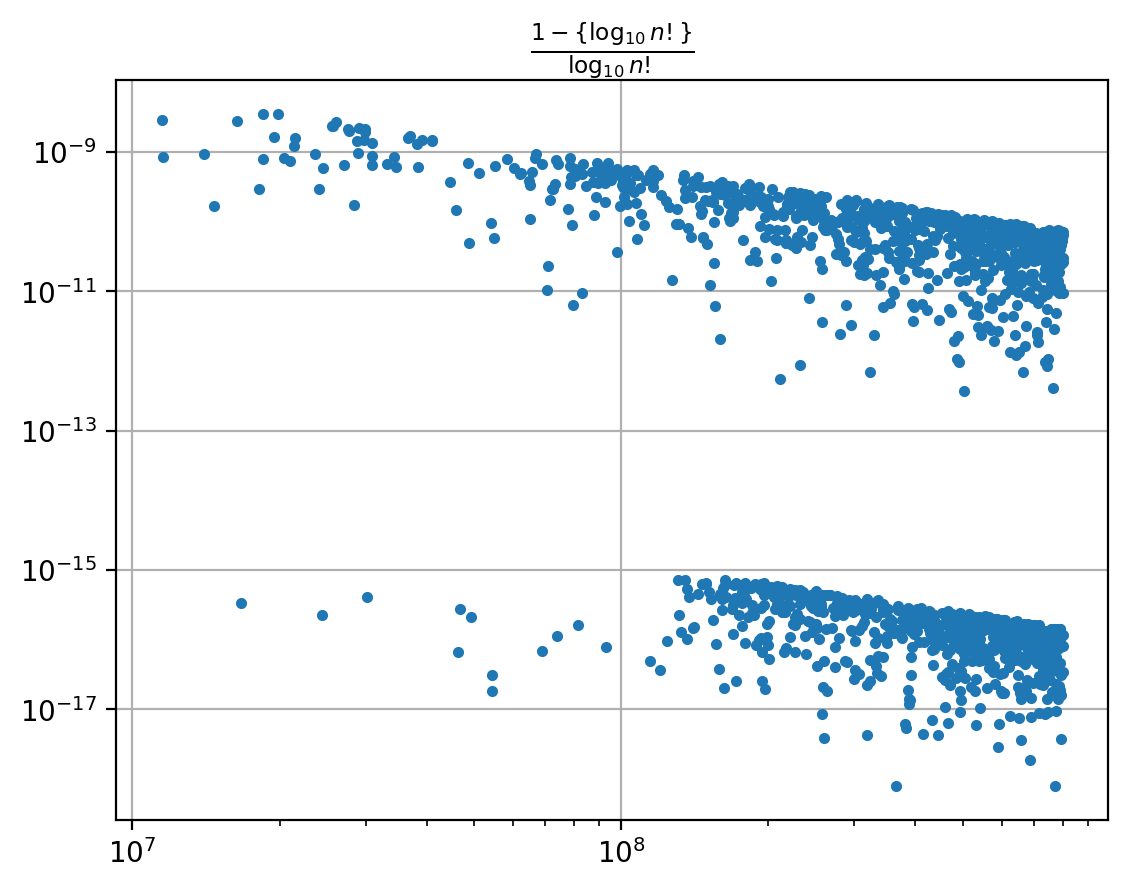

In [19]:
fig, ax = plt.subplots()
ax.set_title(r"$\frac{1 - \left\{ \log_{10} n! \right\}}{\log_{10} n!}$")
ax.plot(g_number, g_1f, ".")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.show()